# Circuits

*This is an executable IPython Notebook tutorial.*

In [1]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
from jax import jit, grad
import jax.numpy as jnp
from math import prod
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import optax
import functools

# Basics

`jaxquantum.circuits` is a submodule of JAXquantum dedicated to multi-mode, gate parameterized quantum simulations. 

Our circuit design is inspired by [Qiskit](https://www.ibm.com/quantum/qiskit) and [Cirq](https://quantumai.google/cirq). 

A JAXquantum circuit begins with a `Register`, which specifies the Hilbert space dimensions of the modes involved in the circuit. 

The `Circuit` class is then defined by the `Register` of modes it affects and its `Layer` objects. Each `Layer` consists of `Operation` objects, which are specified by a `Gate` and the register indices on which that gate acts. Finally, a `Gate` can be specified by a unitary operator, a Hamiltonian (with timesteps and collapse operators), or a Kraus map. 

To better understand how this object hierarchy works, let's work through a simple example. 

100%|██████████| 2/2 [00:00<00:00, 412.52it/s]


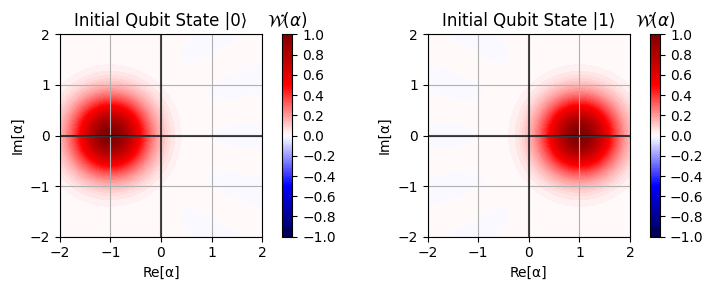

In [2]:
N = 10
beta = 2
reg = jqtc.Register([2,N])
cirq = jqtc.Circuit.create(reg, layers=[])
cirq.append(jqtc.X(),0)
cirq.append(jqtc.CD(N, beta),[0,1])


fig, axs = plt.subplots(1, 2, figsize=(8, 3))

for j in range(2):
    initial_state = jqt.basis(2,j) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state)

    pts = jnp.linspace(-2,2, 101)
    ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts, ax=axs[j])
    ax.set_title(f"Initial Qubit State |{j}⟩")
    ax.set_xlabel("Re[α]")
    ax.set_ylabel("Im[α]")

fig.tight_layout()

The `jqtc.simulate` function takes a kwarg called `mode`, which can either be `"unitary"`, `"kraus"`, `"hamiltonian"` or `"default"` - as enumerated by the `SimulateMode` Enum class. By default, the simulation mode is "default". This means, the default simulation mode of each layer will be used to simulate that layer of the circuit. The `default_simulate_mode` of a layer is specified upon creation of that layer and by default the `default_simulate_mode` is set to `"unitary"` for a new layer. 

To illustrate these features, we will include a layer with one operation consisting of a gate that resets the qubit to the $\ket{+}$ state. This layer will be simulated as a Kraus map, by setting `default_simulate_mode="kraus"`. 

Using this reset operation, we will be able to create a cat state in the resonator. 

$$\begin{align}&\ket{g}\ket{0} \\&\to \ket{+}\ket{0} \\&\to \ket{g}\ket{\beta/2} + \ket{e}\ket{-\beta/2}\\&\to\ket{+}\left(\frac{\ket{\beta/2} + \ket{-\beta/2}}{\sqrt{2}}\right) + \ket{-}\left(\frac{\ket{\beta/2} - \ket{-\beta/2}}{\sqrt{2}}\right)\\&\to \ket{+}\left(\frac{\ket{\beta/2} + \ket{-\beta/2}}{\sqrt{2}}\right)\end{align}$$

The entire sequence shown above is performed by the code written below.

100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


Text(62.44444444444453, 0.5, 'Im[α]')

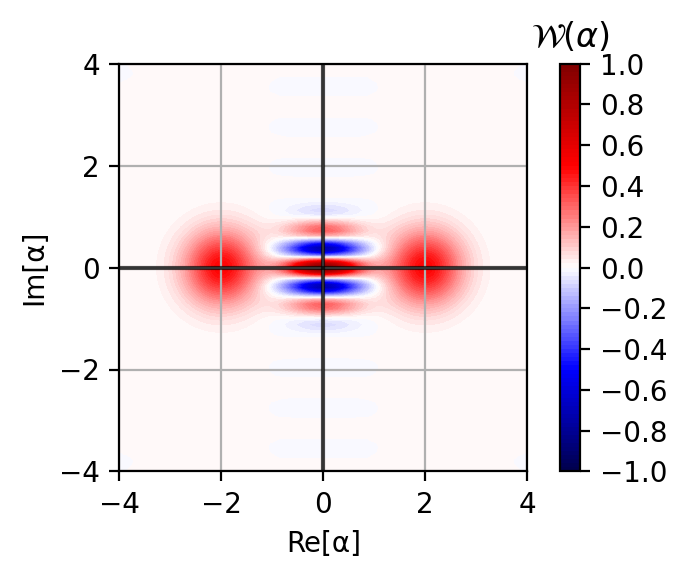

In [3]:
N = 40
beta = 4
reg = jqtc.Register([2,N])
cirq = jqtc.Circuit.create(reg, layers=[])
cirq.append(jqtc.H(),0)
cirq.append(jqtc.CD(N, beta),[0,1])
cirq.append(jqtc.MX_plus(), 0, default_simulate_mode="kraus")

initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
res = jqtc.simulate(cirq, initial_state)

final_state = res[-1][-1].unit()

pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(final_state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

# Optimization

As usual, every function written using `jaxquantum` is auto-differentiable. This allows us to perform gradient-aware optimizations. 

In the cells below, we detail a very simple example of a `jaxquantum` circuit optimization. Here, we optimize over the qubit rotation angle $\theta$ to achieve a pi pulse taking $\ket{0}$ to $\ket{1}$.

100%|██████████| 1/1 [00:00<00:00, 113.45it/s]


Test 0.024471741852423127 [-0.97080552]


100%|██████████| 1000/1000 [00:02<00:00, 393.46it/s]


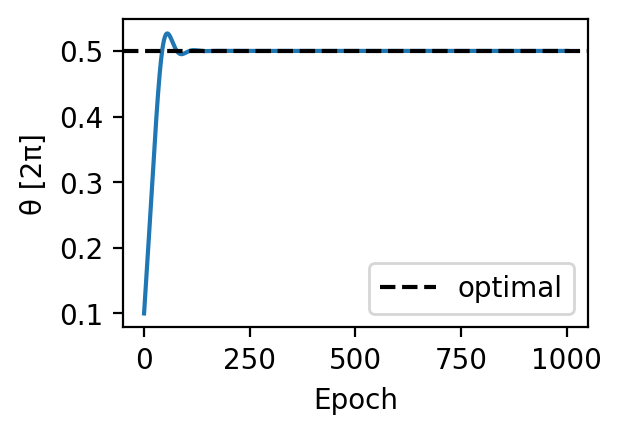

In [4]:
# Setup metric =======
@jit
def metric(params):
    theta = 2*jnp.pi*params[0]
    reg = jqtc.Register([2])
    cirq = jqtc.Circuit.create(reg, layers=[])
    cirq.append(jqtc.Rx(theta),0)

    initial_state = jqt.basis(2,0)
    res = jqtc.simulate(cirq, initial_state)

    final_state = res[-1][-1]
    target_state = jqt.basis(2,1)
    return 1-jqt.overlap(final_state, target_state)

metric_grad = grad(metric)
print("Test", metric(jnp.array([0.45])), metric_grad(jnp.array([0.45])))
# ======


# Setup Optimizer ======
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = jnp.array([0.1])
opt_state = optimizer.init(params)
# ======

# Run optimization ======
params_history = [params[0]]
for _ in tqdm(range(1000)):
  grads = metric_grad(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params_history.append(params[0])

params_history = jnp.array(params_history)
# ======

# Plot parameter history ======
fig, ax = plt.subplots(1,1, dpi=200, figsize=(3,2))
ax.plot(params_history)
ax.axhline(0.5, ls="--", color="black", label="optimal")
ax.set_xlabel("Epoch")
ax.set_ylabel("θ [2π]")
ax.legend()
# ======

For a more practical example of offline state preparation optimizations, check out `experiments/circuit/10-jax-control-gkp-reg.ipynb` on the main branch of the `jaxquantum` repo. This will be polished into a tutorial in the future.  

# Hamiltonian Simulations

`jaxquantum` circuits can also be simulated in `"hamiltonian"` mode. In this mode, the Hamiltonians of operations within the same layer will be added together. This allows us to perform a displacement on a resonator, while it is dispersively coupled to a qubit. Because of the alway-on dispersive coupling, there is a conditional displacement orthogonal to the direction of the displacement gate and conditional on the state of the qubit (pushing the resonator state one way when the qubit is in $\ket{g}$ and the opposite way when the qubit is in $\ket{e}$).

100% |██████████| [00:00<00:00, 10991.36%/s]
100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
100% |██████████| [00:00<00:00, 12007.74%/s]
100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


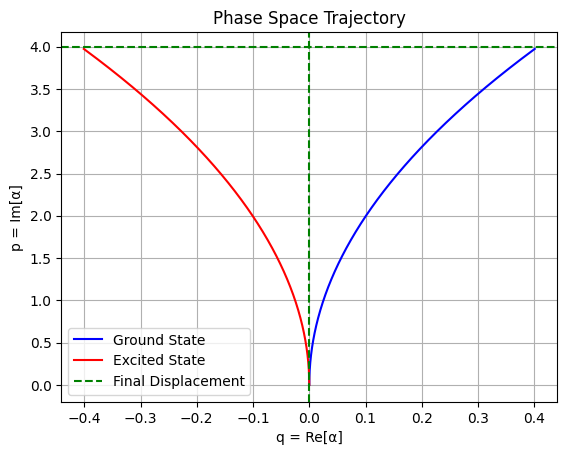

In [5]:
displacement_final = 4.0j # try increasing this to get a larger final displacement!
Na = 100 # and try increasing the resonator size to accommodate larger displacements!
Nq = 2

a = jqt.destroy(Na) ^ jqt.identity(Nq)
sz = jqt.identity(Na) ^ jqt.sigmaz()


# Dispersive coupling strength is 32kHz
χ = 2 * jnp.pi * 32e-6 # [2pi x GHz]

t_final = 1000 # [ns]
g_d = displacement_final / t_final / 2
ts = jnp.linspace(0, t_final, 1001)


def Ht(t):
    H = χ * (a.dag() @ a) @ sz
    return H

reg = jqtc.Register([Na,Nq])
cirq = jqtc.Circuit.create(reg, layers=[])

# Displacement gate
D_gate = jqtc.D(Na, displacement_final, ts=ts)

# Idle gate accounts for the always-on dispersive coupling
Idle_gate = jqtc.Id([Na,Nq])
Idle_gate = Idle_gate.add_Ht(Ht)

# Displacement gate and idle gate are on the same layer
cirq.append(D_gate, 0, default_simulate_mode="hamiltonian")
cirq.append(Idle_gate, [0,1], new_layer=False)


# Qubit begins in ground state, resonator in vacuum state
initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 0)
res_g = jqtc.simulate(cirq, initial_state, mode="default")

# Qubit begins in excited state, resonator in vacuum state
initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 1)
res_e = jqtc.simulate(cirq, initial_state, mode="default")


# Plot ======

results_g = res_g[1]
results_e = res_e[1]

q = (a + a.dag())
p = 1j * (a.dag() - a)

q_exp_t_g = jqt.overlap(results_g, q)
p_exp_t_g = jqt.overlap(results_g, p)
q_exp_t_e = jqt.overlap(results_e, q)
p_exp_t_e = jqt.overlap(results_e, p)

plt.plot(q_exp_t_g.real, p_exp_t_g.real, color="blue", label="Ground State")
plt.plot(q_exp_t_e.real, p_exp_t_e.real, color="red", label="Excited State")

plt.axhline(jnp.imag(displacement_final), color="green", linestyle="--", label="Final Displacement")
plt.axvline(jnp.real(displacement_final), color="green", linestyle="--")

plt.xlabel("q = Re[α]")
plt.ylabel("p = Im[α]")
plt.title("Phase Space Trajectory")
plt.legend()
plt.grid()
plt.show()

### Echoed Conditional Displacement Gate

Here, we extend the last example to simulate the full echoed conditional displacement gate, as done in Sivak et al. Nature (2023) and as shown below.

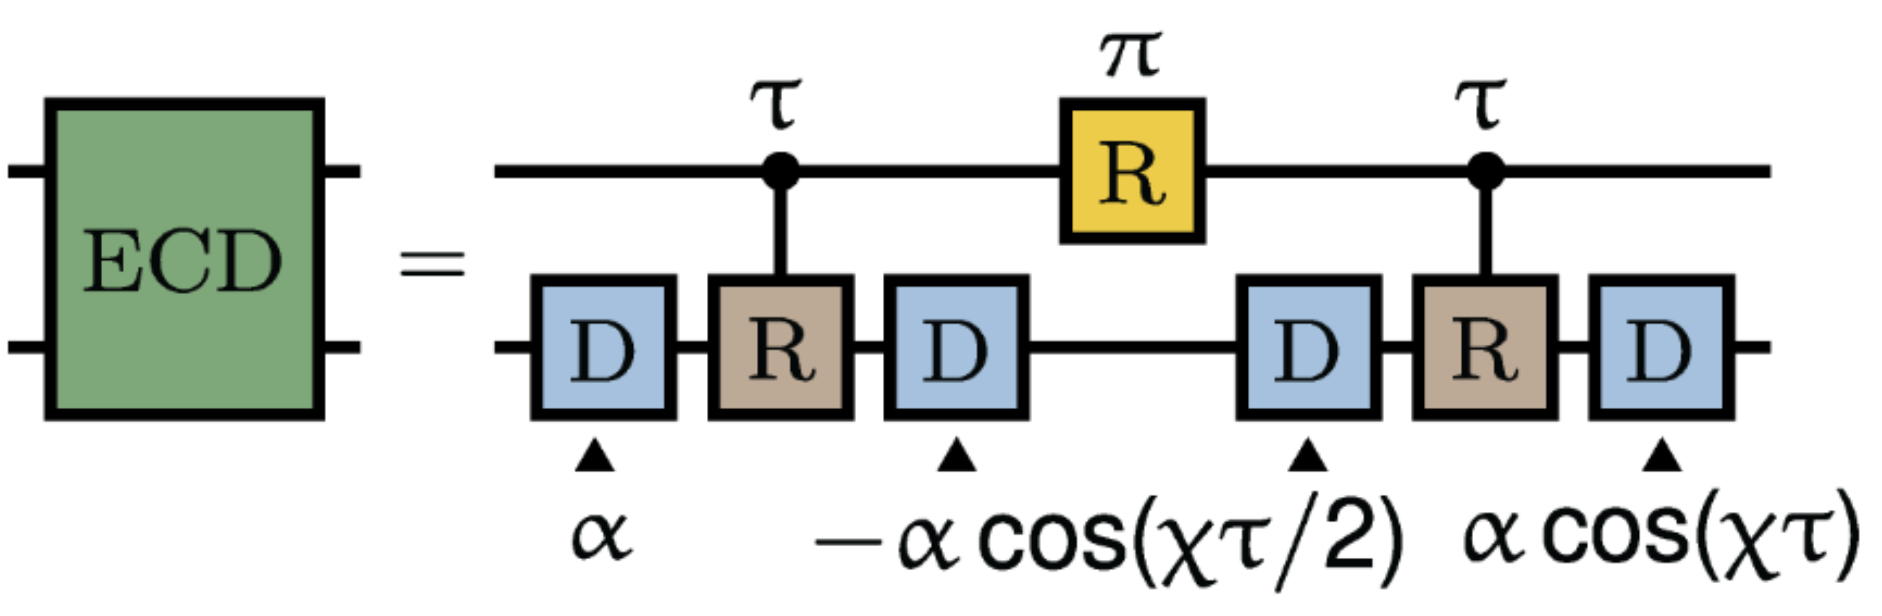

100% |██████████| [00:00<00:00, 11332.59%/s]
100% |██████████| [00:00<00:00, 15979.52%/s]
100% |██████████| [00:00<00:00, 11473.01%/s]
100% |██████████| [00:00<00:00, 11478.04%/s]
100% |██████████| [00:00<00:00, 16159.91%/s]
100% |██████████| [00:00<00:00, 11535.49%/s]
100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
100% |██████████| [00:00<00:00, 11920.38%/s]
100% |██████████| [00:00<00:00, 14476.10%/s]
100% |██████████| [00:00<00:00, 11246.29%/s]
100% |██████████| [00:00<00:00, 11350.68%/s]
100% |██████████| [00:00<00:00, 15544.82%/s]
100% |██████████| [00:00<00:00, 11649.55%/s]
100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


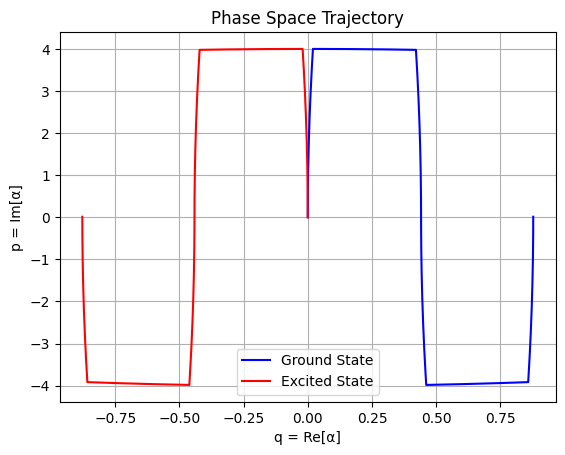

In [6]:
# Setup simulation ====
alpha = 4.0j # try increasing this to get a larger final displacement!
delay_time = 1000
Na = 100 # and try increasing the resonator size to accommodate larger displacements!
Nq = 2

a = jqt.destroy(Na) ^ jqt.identity(Nq)
sz = jqt.identity(Na) ^ jqt.sigmaz()

# Dispersive coupling strength is 32kHz
χ = 2 * jnp.pi * 32e-6 # [2pi x GHz]
ts = jnp.linspace(0, 100, 1001) # [ns]


def Ht(t):
    H = χ * (a.dag() @ a) @ sz / 2
    return H

idle_gate = jqtc.Id([Na,Nq]) # no times specified
idle_gate = idle_gate.add_Ht(Ht)

delay_gate = jqtc.Id([Na,Nq], ts=jnp.linspace(0, delay_time, 1001))
delay_gate = delay_gate.add_Ht(Ht)

reg = jqtc.Register([Na,Nq])
cirq = jqtc.Circuit.create(reg, layers=[])

# Step 1: Displace out
cirq.append(jqtc.D(Na, alpha, ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)

# Step 2: Wait
cirq.append(delay_gate.copy(), [0,1], default_simulate_mode="hamiltonian")

# Step 3: Displace back
cirq.append(jqtc.D(Na, -alpha*jnp.cos(χ*delay_time/2), ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)

# Step 4: Qubit pi pulse
cirq.append(jqtc.X(), 1)

# Step 5: Displace out again
cirq.append(jqtc.D(Na, -alpha*jnp.cos(χ*delay_time/2), ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)

# Step 6: Wait
cirq.append(delay_gate.copy(), [0,1], default_simulate_mode="hamiltonian")

# Step 7: Displace back
cirq.append(jqtc.D(Na, alpha*jnp.cos(χ*delay_time), ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)
# ====

# Simulate ====

initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 0)
res_g = jqtc.simulate(cirq, initial_state, mode="default")

initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 1)
res_e = jqtc.simulate(cirq, initial_state, mode="default")
# =====

# Plot ====
q = (a + a.dag())
p = 1j * (a.dag() - a)

q_exp_t_g = jnp.concatenate([jqt.overlap(res_g_i, q) for res_g_i in res_g])
p_exp_t_g = jnp.concatenate([jqt.overlap(res_g_i, p) for res_g_i in res_g])
q_exp_t_e = jnp.concatenate([jqt.overlap(res_e_i, q) for res_e_i in res_e])
p_exp_t_e = jnp.concatenate([jqt.overlap(res_e_i, p) for res_e_i in res_e])

plt.plot(q_exp_t_g.real, p_exp_t_g.real, color="blue", label="Ground State")
plt.plot(q_exp_t_e.real, p_exp_t_e.real, color="red", label="Excited State")

plt.xlabel("q = Re[α]")
plt.ylabel("p = Im[α]")
plt.title("Phase Space Trajectory")
plt.legend()
plt.grid()
plt.show()
# ====